<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>







In [ ]:
import numpy as np
import copy
import numpy as np
import os

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch
import torchvision
from torchvision import transforms
from torchsummary import summary

from torchvision.datasets import MNIST
from torchvision import transforms as tfs

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Сгенерируем датасет:

In [ ]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

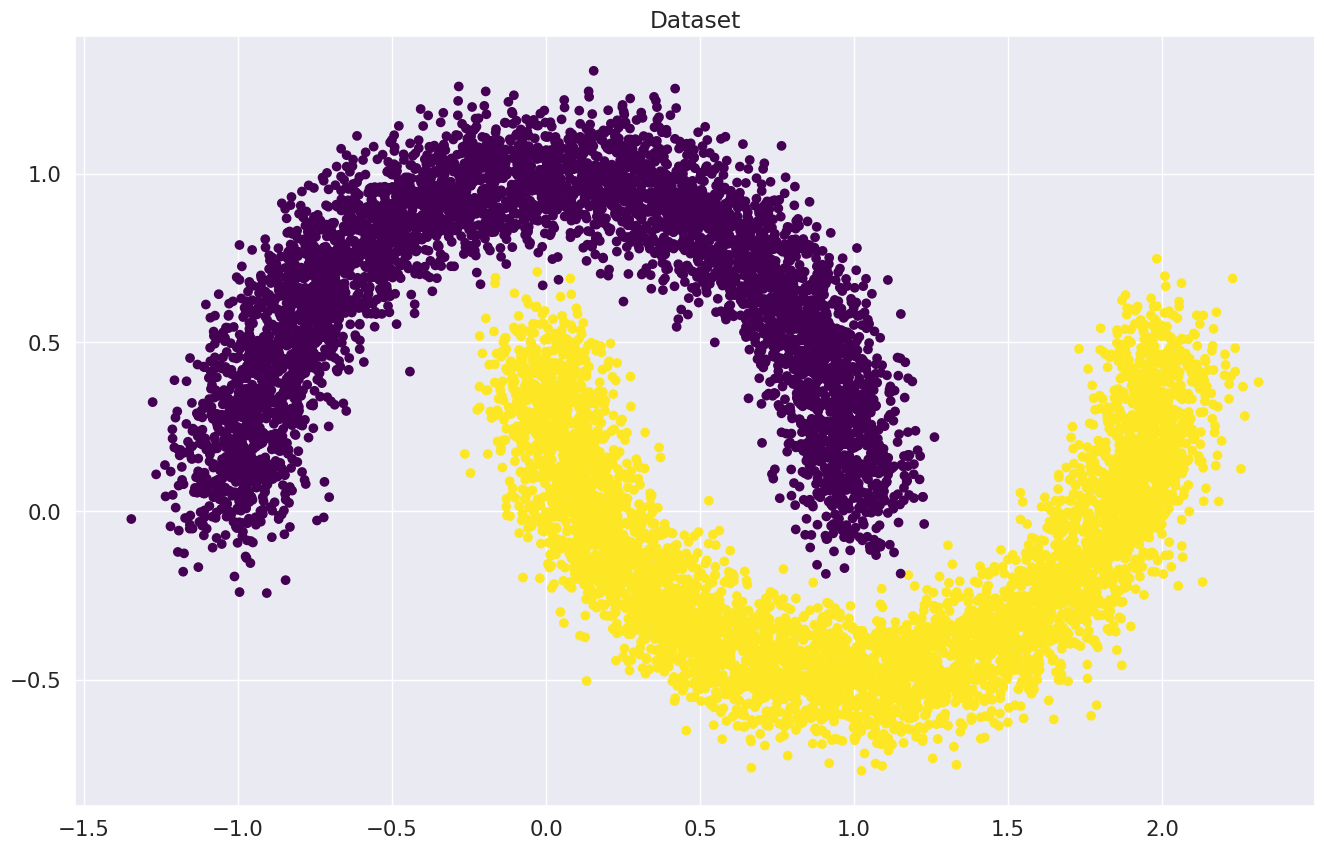

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузчики данных:

Создаем тензоры:

In [ ]:
X_train_t =  torch.tensor(X_train)
y_train_t =  torch.tensor(y_train)
X_val_t =  torch.tensor(X_val)
y_val_t =  torch.tensor(y_val)

Создаем `Dataset` и `DataLoader`.

In [ ]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

### Реализация логистической регрессии:


In [ ]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(out_features, in_features).double())  # Инициализация весов
        self.bias = bias # Инициализация смещения
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features).double())

    def forward(self, x):
        x = torch.matmul(x.double(), self.weights.T.double())  # Применение весов и транспонирование с типом Double
        if self.bias:
            x += self.bias_term  # Применение смещения
        return x

In [ ]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

### Реализация цикла обучения:

In [ ]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()

        # Преобразование данных к типу Double
        X_batch = X_batch.double()
        y_batch = y_batch.view(-1, 1).double()  # Изменение размерности y_batch

        outp = linear_regression(X_batch)  # Получение выходных данных с помощью linear_regression
        loss = loss_function(outp, y_batch)  # Вычисление потерь
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()

        probabilities = torch.sigmoid(outp)  # Вычисление вероятностей с помощью сигмоиды
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch.flatten()).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")

        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}. Сходимость. Прекращение итераций.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.4296875
Iteration: 100
Batch accuracy: 0.59375
Iteration: 200
Batch accuracy: 0.71875
Iteration: 300
Batch accuracy: 0.7734375
Iteration: 400
Batch accuracy: 0.75
Iteration: 500
Batch accuracy: 0.859375
Iteration: 600
Batch accuracy: 0.828125
Iteration: 700
Batch accuracy: 0.78125
Iteration: 800
Batch accuracy: 0.8046875
Iteration: 900
Batch accuracy: 0.8046875

Iteration: 995. Сходимость. Прекращение итераций.


Алгоритм сошелся после 995 итераций

### Визуализируем результаты

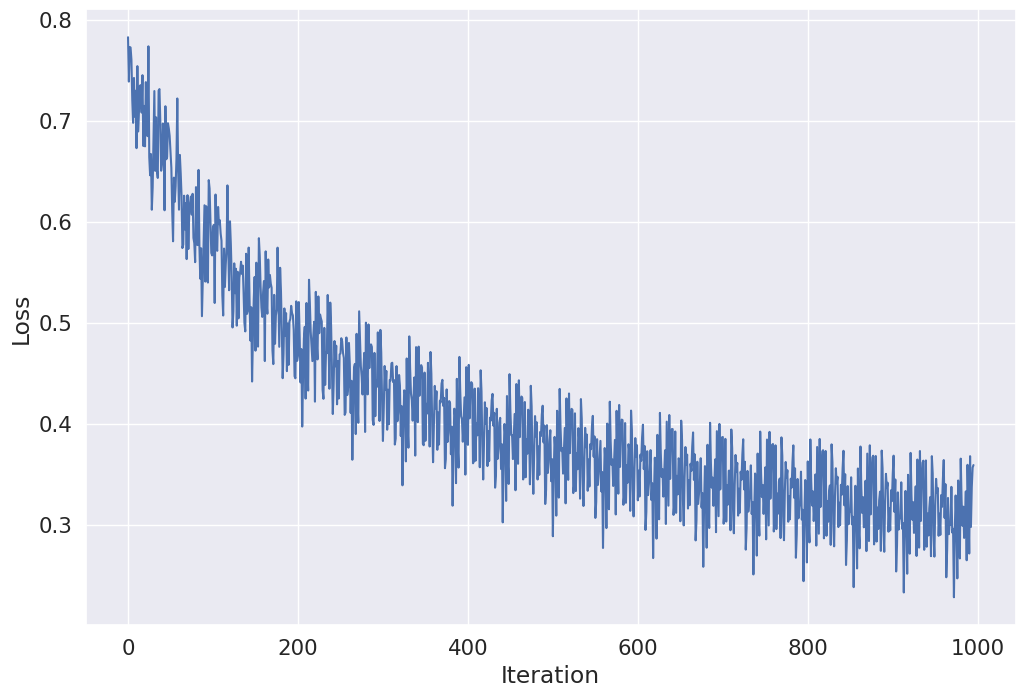

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

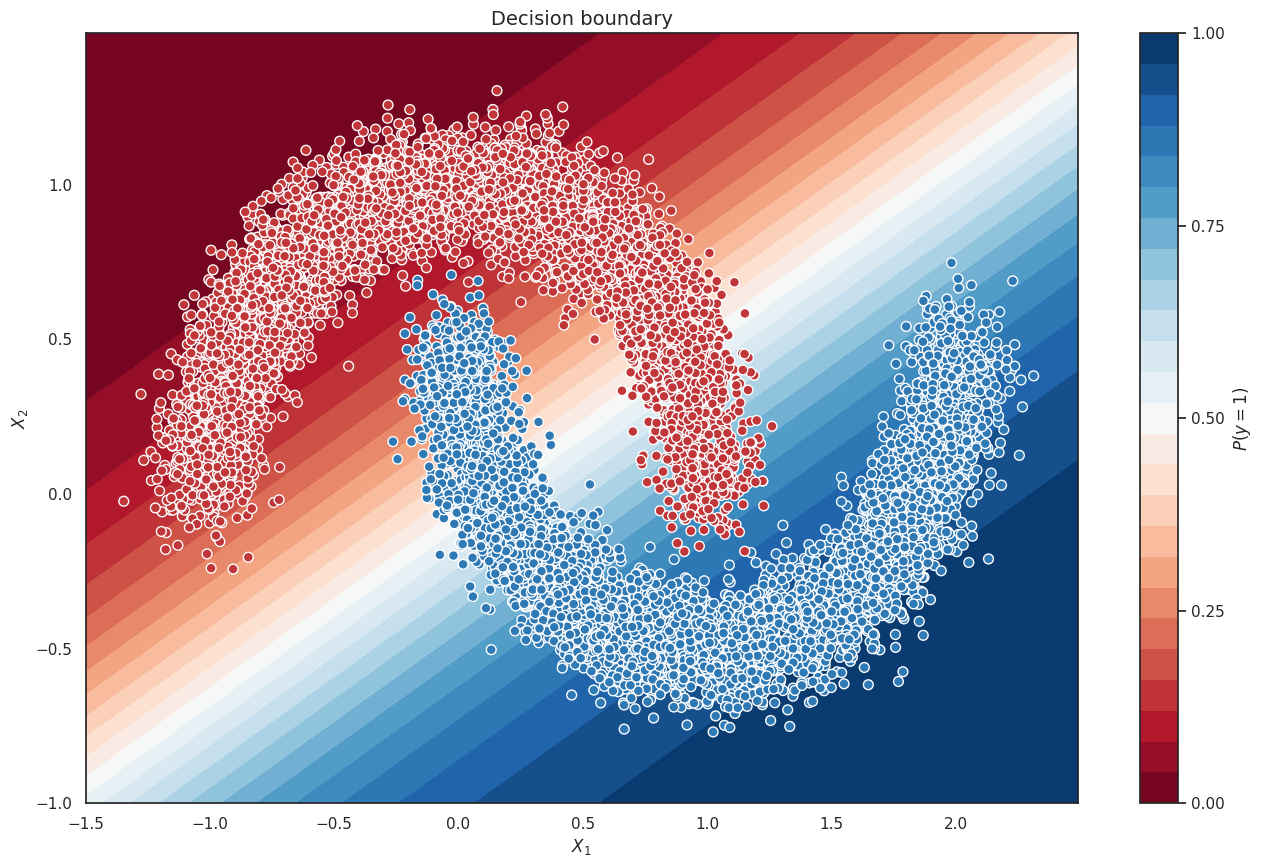

In [ ]:
sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Функция predict и расчет accuracy:

In [ ]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        X_batch = x_batch.double()
        outp = model(x_batch)  # Получение выходных данных с помощью linear_regression
        probabilities = torch.sigmoid(outp)  # Вычисление вероятностей с помощью сигмоиды
        preds = (probabilities > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [ ]:
# Получение предсказаний с помощью функции predict
predictions = predict(val_dataloader, linear_regression)

# Преобразование истинных меток в массив
true_labels = np.array([])
for _, y_batch in val_dataloader:
    true_labels = np.hstack((true_labels, y_batch.numpy().flatten()))

# Вычисление общей точности
total_accuracy = accuracy_score(true_labels, predictions)

print(f"Общая точность: {total_accuracy * 100:.2f}%")

Общая точность: 85.56%


# Часть 2. Датасет MNIST

In [ ]:
data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                          shuffle=True, num_workers=2)
valid_dataloader =  torch.utils.data.DataLoader(val_dataset, batch_size=4,
                                         shuffle=False, num_workers=2)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15577010.65it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 482879.74it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4372212.49it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3886276.78it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [ ]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Простая полносвязная нейронная сеть

Создадим полносвязную нейронную сеть с помощью класса Sequential.
Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Лосс для обучения - кросс-энтропия.


In [ ]:
activation = nn.ELU()

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=784, out_features=128),
    activation,
    nn.Linear(in_features=128, out_features=128),
    activation,
    nn.Linear(128, 10)
)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Обучение:

In [ ]:
max_epochs = 10
accuracy = {"train": [], "valid": []}

for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()  # Переводим модель в режим train
                optimizer.zero_grad()  # Обнуляем градиенты

                outp = model(x_batch)  # Вычисляем выход модели
                loss = criterion(outp, y_batch)  # Вычисляем лосс
                loss.backward()  # Считаем градиенты
                optimizer.step()  # Обновляем веса

            else:
                model.eval()  # Переводим модель в режим eval
                with torch.no_grad():  # Не считаем градиенты
                    outp = model(x_batch)  # Вычисляем выход модели

            preds = outp.argmax(dim=1)  # Получаем предсказания классов
            correct = (preds == y_batch).sum().item()  # Вычисляем количество правильных предсказаний
            all = y_batch.size(0)  # Общее количество данных в батче

            epoch_correct += correct  # Обновляем общее количество правильных предсказаний
            epoch_all += all  # Обновляем общее количество данных в эпохе

        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct / epoch_all}")
        accuracy[k].append(epoch_correct / epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.90805
Loader: valid. Accuracy: 0.9409
Epoch: 2
Loader: train. Accuracy: 0.9476333333333333
Loader: valid. Accuracy: 0.9466
Epoch: 3
Loader: train. Accuracy: 0.9551833333333334
Loader: valid. Accuracy: 0.9473
Epoch: 4
Loader: train. Accuracy: 0.96045
Loader: valid. Accuracy: 0.9609
Epoch: 5
Loader: train. Accuracy: 0.96395
Loader: valid. Accuracy: 0.9619
Epoch: 6
Loader: train. Accuracy: 0.9666
Loader: valid. Accuracy: 0.9647
Epoch: 7
Loader: train. Accuracy: 0.9679166666666666
Loader: valid. Accuracy: 0.9513
Epoch: 8
Loader: train. Accuracy: 0.9696166666666667
Loader: valid. Accuracy: 0.9651
Epoch: 9
Loader: train. Accuracy: 0.9698
Loader: valid. Accuracy: 0.963
Epoch: 10
Loader: train. Accuracy: 0.97135
Loader: valid. Accuracy: 0.9648


### Функции активации:
Попробуем разные функции активации. Для каждой функции активации посчитаем массив validation accuracy

In [ ]:
elu_accuracy = accuracy["valid"]

In [ ]:
def test_activation_function(activation_func):
    # Определение модели с заданной функцией активации
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=784, out_features=128),
        activation_func,
        nn.Linear(in_features=128, out_features=128),
        activation_func,
        nn.Linear(128, 10)
    )

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    accuracy = []

    for epoch in range(max_epochs):
        epoch_correct = 0
        epoch_all = 0

        for k, dataloader in loaders.items():
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)

                preds = outp.argmax(dim=1)
                correct = (preds == y_batch).sum().item()
                all = y_batch.size(0)

                epoch_correct += correct
                epoch_all += all

        acc = epoch_correct / epoch_all
        accuracy.append(acc)

    return accuracy

In [ ]:
plain_accuracy = test_activation_function(nn.Identity())
relu_accuracy = test_activation_function(nn.ReLU())
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU())

### Результаты accuracy:
Построим график accuracy/epoch для каждой функции активации.

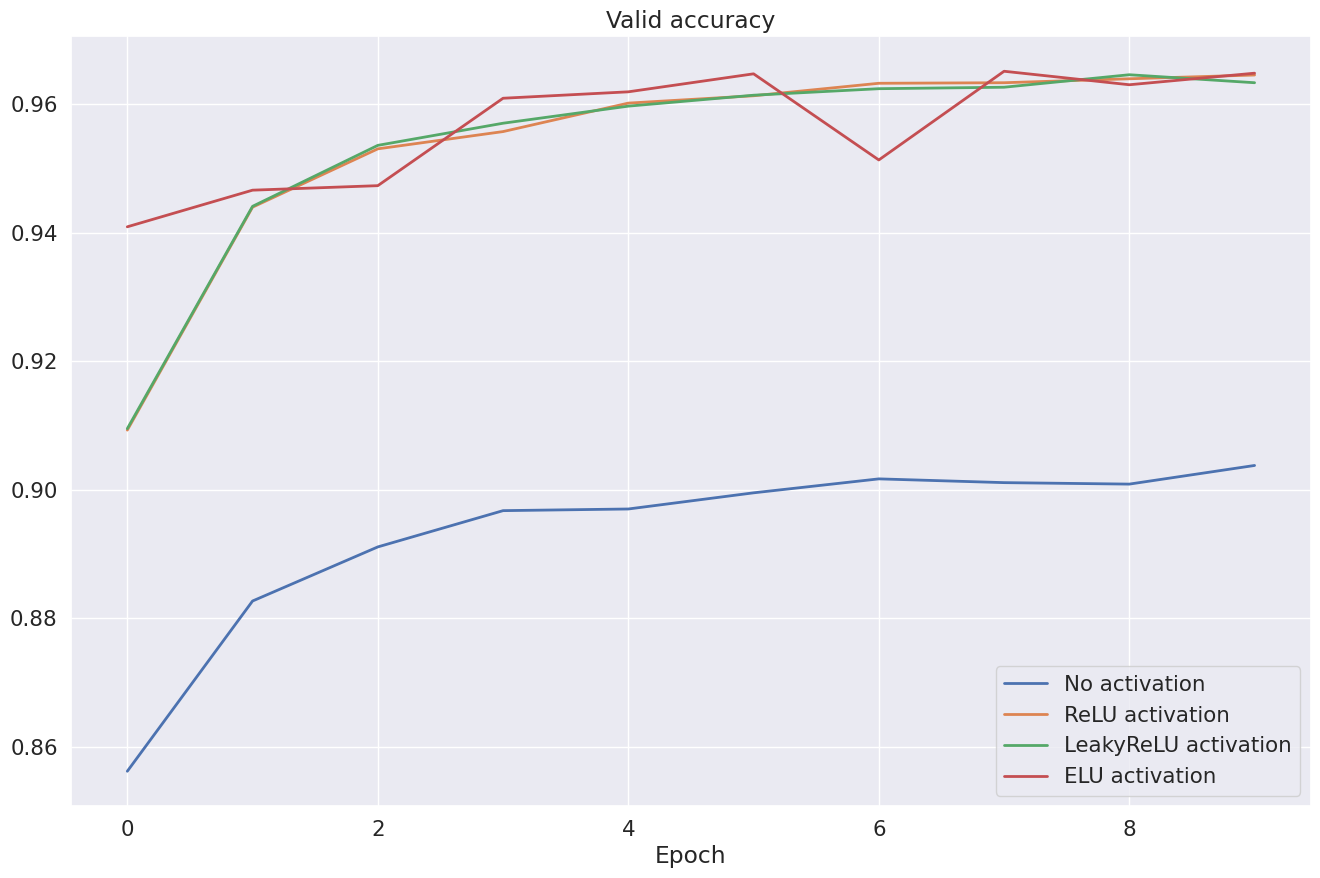

In [ ]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вывод** Лучший результат получен с функциями активаций `ReLU` и `LeakyReLU activation`

## Часть 2.2 Сверточные нейронные сети

### Архитектура LeNet:

Нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        print(x.size())
        x = x.view(-1, 16*5*5)
        #print(x.size())
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Обучение:
Обучим нейросеть и сравним результаты классификации сверточной нейросети с полносвязной на датасете MNIST на том же количестве эпох(=10):

In [ ]:
max_epochs = 10
accuracy = {"train": [], "valid": []}

for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()  # Переводим модель в режим train
                optimizer.zero_grad()  # Обнуляем градиенты

                outp = model(x_batch)  # Вычисляем выход модели
                loss = criterion(outp, y_batch)  # Вычисляем лосс
                loss.backward()  # Считаем градиенты
                optimizer.step()  # Обновляем веса

            else:
                model.eval()  # Переводим модель в режим eval
                with torch.no_grad():  # Не считаем градиенты
                    outp = model(x_batch)  # Вычисляем выход модели

            preds = outp.argmax(dim=1)  # Получаем предсказания классов
            correct = (preds == y_batch).sum().item()  # Вычисляем количество правильных предсказаний
            all = y_batch.size(0)  # Общее количество данных в батче

            epoch_correct += correct  # Обновляем общее количество правильных предсказаний
            epoch_all += all  # Обновляем общее количество данных в эпохе

        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct / epoch_all}")
        accuracy[k].append(epoch_correct / epoch_all)

Выходные данные были обрезаны до нескольких последних строк (5000).
torch.Size([4, 16, 5, 5])
torch.Size([4, 16, 5, 5])
torch.Size([4, 16, 5, 5])
torch.Size([4, 16, 5, 5])
torch.Size([4, 16, 5, 5])
torch.Size([4, 16, 5, 5])
torch.Size([4, 16, 5, 5])
torch.Size([4, 16, 5, 5])
torch.Size([4, 16, 5, 5])
torch.Size([4, 16, 5, 5])
torch.Size([4, 16, 5, 5])
torch.Size([4, 16, 5, 5])
torch.Size([4, 16, 5, 5])
torch.Size([4, 16, 5, 5])
torch.Size([4, 16, 5, 5])
torch.Size([4, 16, 5, 5])
torch.Size([4, 16, 5, 5])
torch.Size([4, 16, 5, 5])
torch.Size([4, 16, 5, 5])
torch.Size([4, 16, 5, 5])
torch.Size([4, 16, 5, 5])
torch.Size([4, 16, 5, 5])
torch.Size([4, 16, 5, 5])
torch.Size([4, 16, 5, 5])
torch.Size([4, 16, 5, 5])
torch.Size([4, 16, 5, 5])
torch.Size([4, 16, 5, 5])
torch.Size([4, 16, 5, 5])
torch.Size([4, 16, 5, 5])
torch.Size([4, 16, 5, 5])
torch.Size([4, 16, 5, 5])
torch.Size([4, 16, 5, 5])
torch.Size([4, 16, 5, 5])
torch.Size([4, 16, 5, 5])
torch.Size([4, 16, 5, 5])
torch.Size([4, 16, 5, 

In [ ]:
lenet_accuracy = accuracy["valid"]

### Результаты accuracy:
Построим график accuracy/epoch для каждой функции активации в сравнении с LeNet:

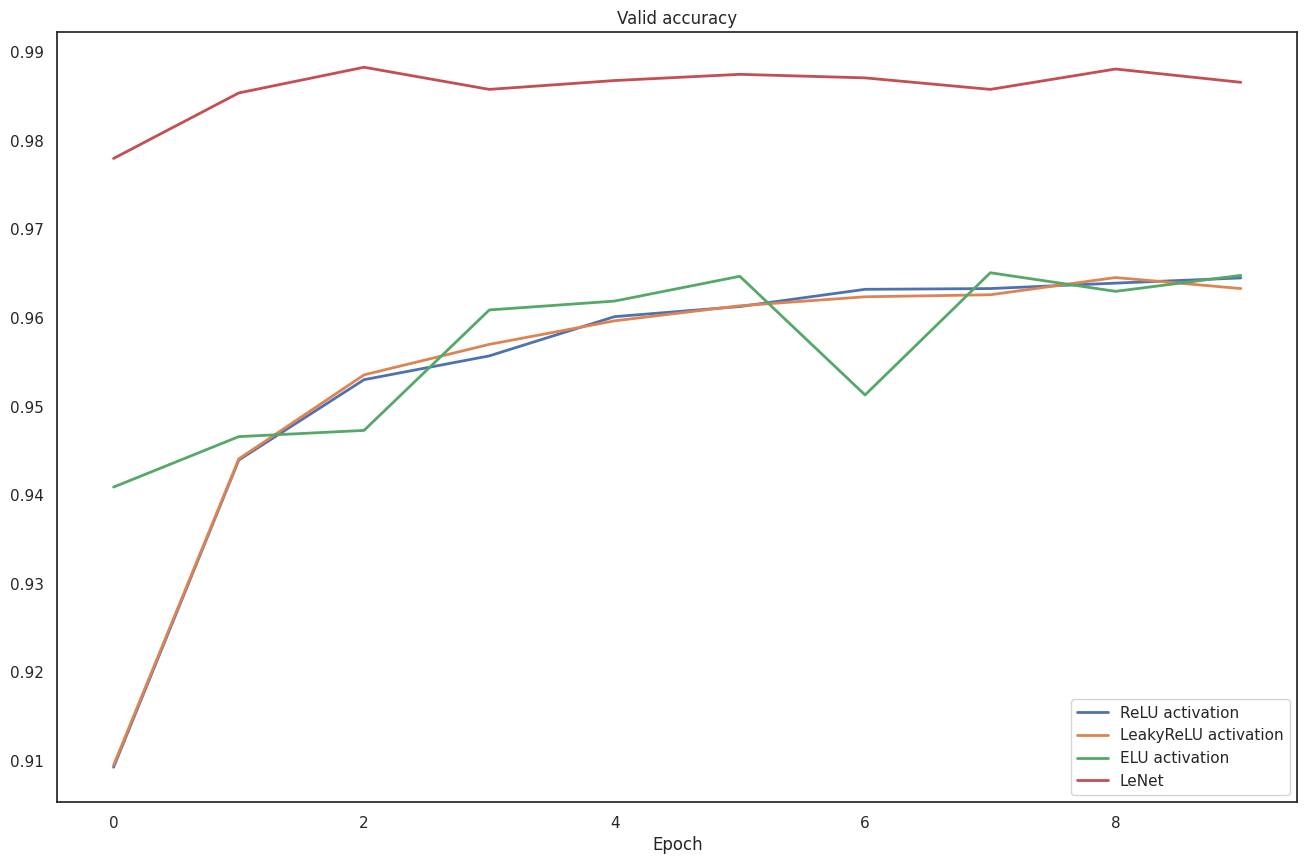

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [ ]:
lenet_accuracy[-1]

0.9866

### Выводы:


**Вывод:**

Сверточные слои в CNN могут улавливать пространственные зависимости и локальные паттерны за счет использования фильтров, которые сканируют изображение по небольшим участкам (рецептивным полям). Эти фильтры позволяют CNN распознавать сложные иерархические признаки, начиная от низкоуровневых (границы, контуры) до высокоуровневых (объекты, лица и т. д.).
Полносвязная нейросеть также с правилась с задачей, где пространственные отношения между пикселями не играют большой роли (как в MNIST). При этом со значительной худшими результатами - 0.96 против 0.987, обучение полносвязно нейросети в данном случае произошло на 40% быстрее, чем у сверточной.